In [1]:
# Import the dependencies.
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect # added inspect as another way to get table names, columns

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine) # useful for getting table names, columns

In [5]:
# Reflect an existing database into a new model
# automap_base is used to automatically reflect an existing database schema into Python classes. 
# It inspects the database and creates Python classes that represent the tables in the database 
# without the need for explicit class definitions. 
Base = automap_base()

# Reflect the tables
# Base.prepare (as opposed to Base.metadata.create_all used with declarative_base) 
# is used for automatic reflection of an existing database schema into Python classes 
# without having to define the classes explicitly.
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print('Table names:')
Base.classes.keys()

# This is another way to get the same result using the inspector object I created
# table_names = inspector.get_table_names()
# table_names

Table names:


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the columns in measurement table

print('Columns in measurement table:')

columns = inspector.get_columns('measurement') 
for column in columns:
    print(column['name'],column['type'])

Columns in measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
date_most_recent = session.query(func.max(Measurement.date)).scalar()
print(f'The most recent date in the data set is {date_most_recent}.')

The most recent date in the data set is 2017-08-23.


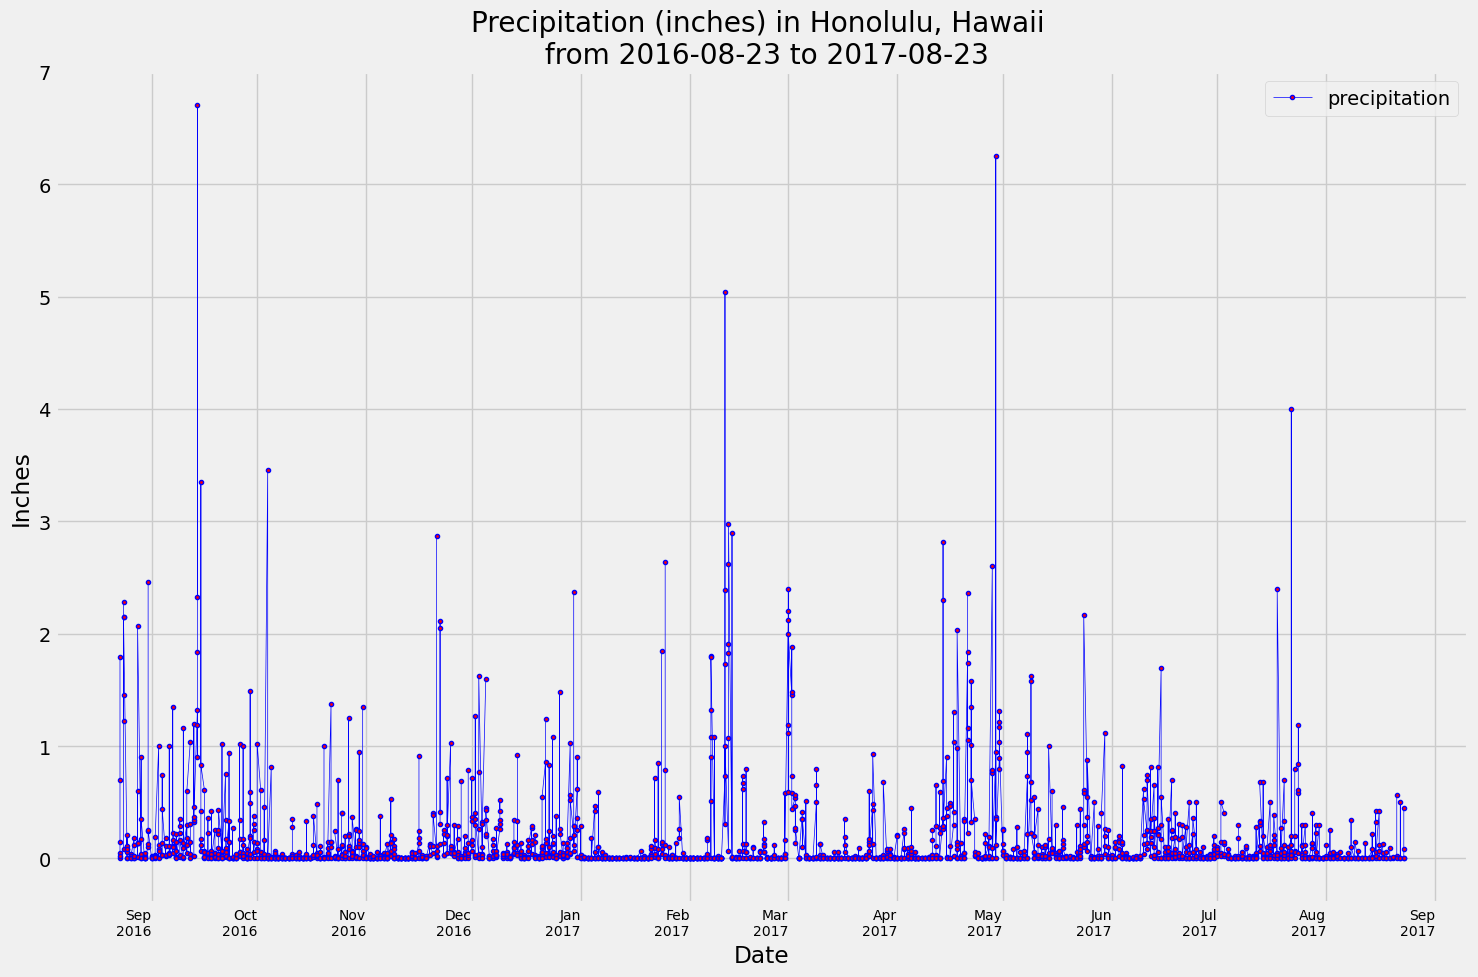

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_one_yr_before_dt = dt.datetime.strptime(date_most_recent, '%Y-%m-%d') - dt.timedelta(days=365)
date_one_yr_before = date_one_yr_before_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores.
data_precip_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_one_yr_before).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
data_precip_last_year_df = pd.DataFrame(data_precip_last_year, 
                                        index = range(len(data_precip_last_year)),
                                        columns = ['date','prcp']
                                        )

# Sort the dataframe by date
data_precip_last_year_df.sort_values(by=['date'], inplace=True)
data_precip_last_year_df['date'] = pd.to_datetime(data_precip_last_year_df['date'], format='%Y-%m-%d')

# Use Pandas Plotting with Matplotlib to plot the data

# Create plot using DataFrame plot method
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
data_precip_last_year_df.plot(ax = ax,
        kind = 'line', 
        style = '-o',
        markersize = 3,
        mfc='red',
        x = 'date',
        y = 'prcp', 
        xlabel = 'Date',
        ylabel = 'Inches',
        title = f'Precipitation (inches) in Honolulu, Hawaii \n from {date_one_yr_before} to {date_most_recent}',
        linewidth = 0.5,
        ylim = [-0.4,7],
        grid = True,
        color = 'blue',
        label = 'precipitation',
        rot = 0
        )
# Set xticks to be one month increments using mdates
loc = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter('%b\n%Y')
ax.xaxis.set_major_formatter(fmt)
ax.tick_params(axis='x', which='major', labelsize=10)

plt.tight_layout()
# Save figure
plt.savefig("Images/Precipitation_Plot.png")
# Show figure
plt.show()

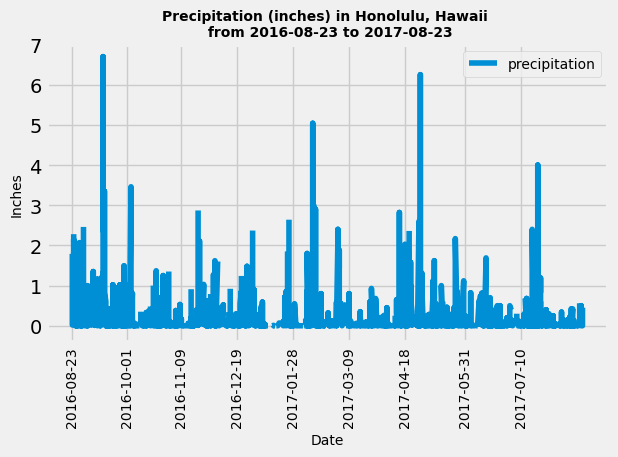

In [12]:
# Another way to plot, this format matches that in Challenge assingment description, but is not a plot method called onto the DataFrame, as requested

# plt.figure(figsize=(15, 10))
plt.plot(data_precip_last_year_df['date'], data_precip_last_year_df['prcp'])

# Set xticks
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 
plt.xticks(xloc, rotation='vertical', fontsize=10)

# Set xlim and ylim
# plt.xlim(0,365)
plt.ylim(-0.4,7)

# Set axis labels and title
plt.xlabel('Date', fontsize=10)
plt.ylabel('Inches',fontsize=10)
plt.title(f'Precipitation (inches) in Honolulu, Hawaii \n from {date_one_yr_before} to {date_most_recent}',fontsize=10, fontweight = 'bold')
plt.rc('ytick',labelsize=10)

# Add legned 
plt.legend(['precipitation'], loc="upper right",fontsize=10)

plt.tight_layout()
# Save figure
plt.savefig("Images/Precipitation_Plot_2.png")
# Show figure
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
print('Summary statistics for the precipitation data:')
data_precip_last_year_df[['prcp']].describe()

Summary statistics for the precipitation data:


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Find the columns in station table 

print('Columns in station table:')

columns = inspector.get_columns('station') 
for column in columns:
    print(column['name'],column['type'])

Columns in station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
# session.query(func.count(Station.id)).scalar() # another way to do it using a func
station_count_distinct = session.query(Station.id).distinct().count() # counts distinct in case there were duplicates
station_count = session.query(Station.id).count() # same as counting distinct, so there are no duplicates to worry about
print(f'There are {station_count} rows in the station table and {station_count_distinct} distinct stations.')

There are 9 rows in the station table and 9 distinct stations.


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_by_measurement_count = session.query(Station.station, func.count(Measurement.station)).\
        filter(Station.station == Measurement.station).\
                group_by(Station.station).\
                        order_by(func.count(Measurement.station).desc()).\
                                all()
print('Stations by measurement count:')
stations_by_measurement_count

Stations by measurement count:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Most active station is the first one in the stations_by_measurement_count list
most_active_station = stations_by_measurement_count[0][0] # USC00519281

# tobs is temperature column in measurement table
# query(*[]) will unpack list
print(f'The lowest, highest, and average temperature (degrees Fahrenheit) of the most active station ({most_active_station}):')
select_statement = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*select_statement).filter(Measurement.station == most_active_station).all()

The lowest, highest, and average temperature (degrees Fahrenheit) of the most active station (USC00519281):


[(54.0, 85.0, 71.66378066378067)]

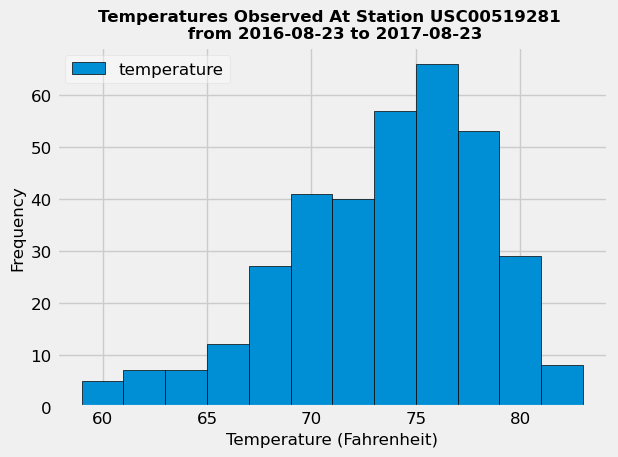

In [18]:
# Using the most active station id (most_active_station = 'USC00519281')
# Query the last 12 months of temperature observation data for this station
temp_data = session.query(Measurement.tobs).\
            filter(Measurement.date.between(date_one_yr_before,date_most_recent)).\
                   filter(Measurement.station == most_active_station).all()

# Plot the results as a histogram
# plt.figure(figsize=(10,10))
plt.hist(np.ravel(temp_data), bins=12, edgecolor='black', linewidth=0.5)
plt.title(f'Temperatures Observed At Station {most_active_station} \n from {date_one_yr_before} to {date_most_recent}',fontsize=12, fontweight = 'bold')
plt.xlabel('Temperature (Fahrenheit)',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(['temperature'], loc = 'upper left', fontsize=12, facecolor='white', framealpha=0.4)

# Set the background color of the plot 
plt.rcParams.update({
    "axes.facecolor":    (0, 0, 0, 0.1),  # grey with alpha = 10%
})

plt.tight_layout()
# Save figure
plt.savefig(f"Images/Station_Plot_{most_active_station}.png")
# Show plot
plt.show()

# Close Session

In [19]:
# Close session
session.close()